# Metasurface conductivity study

The sample spectrum is calculated for a series of conductivity values for the film, and for the region between the antenna capacitors.

In [1]:
import os

import lmfit as lm
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import utils.plotting
from matplotlib.colors import LogNorm, Normalize

## Film conductivity

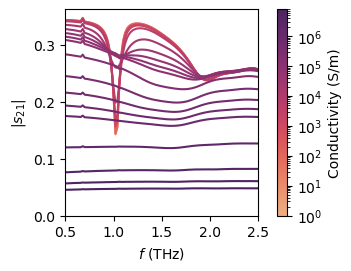

In [2]:
smatrix_data = pl.read_csv("processed_data/film_conductivity.csv", comment_prefix="#")

fig, ax = utils.plotting.plot_s21(smatrix_data)

fig.savefig("figures/film_conductivity_s21.pdf", bbox_inches="tight")
plt.show()

## Gap conductivity

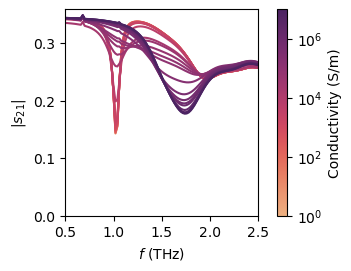

In [4]:
smatrix_data = pl.read_csv("processed_data/gap_conductivity.csv", comment_prefix="#")

fig, ax = utils.plotting.plot_s21(smatrix_data)

fig.savefig("figures/gap_conductivity_21.pdf", bbox_inches="tight")
plt.show()

/var/folders/w0/49sbvg2n73lb899rzwxfzjt80000gn/T/ipykernel_57628/217082801.py:49: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[param].set(


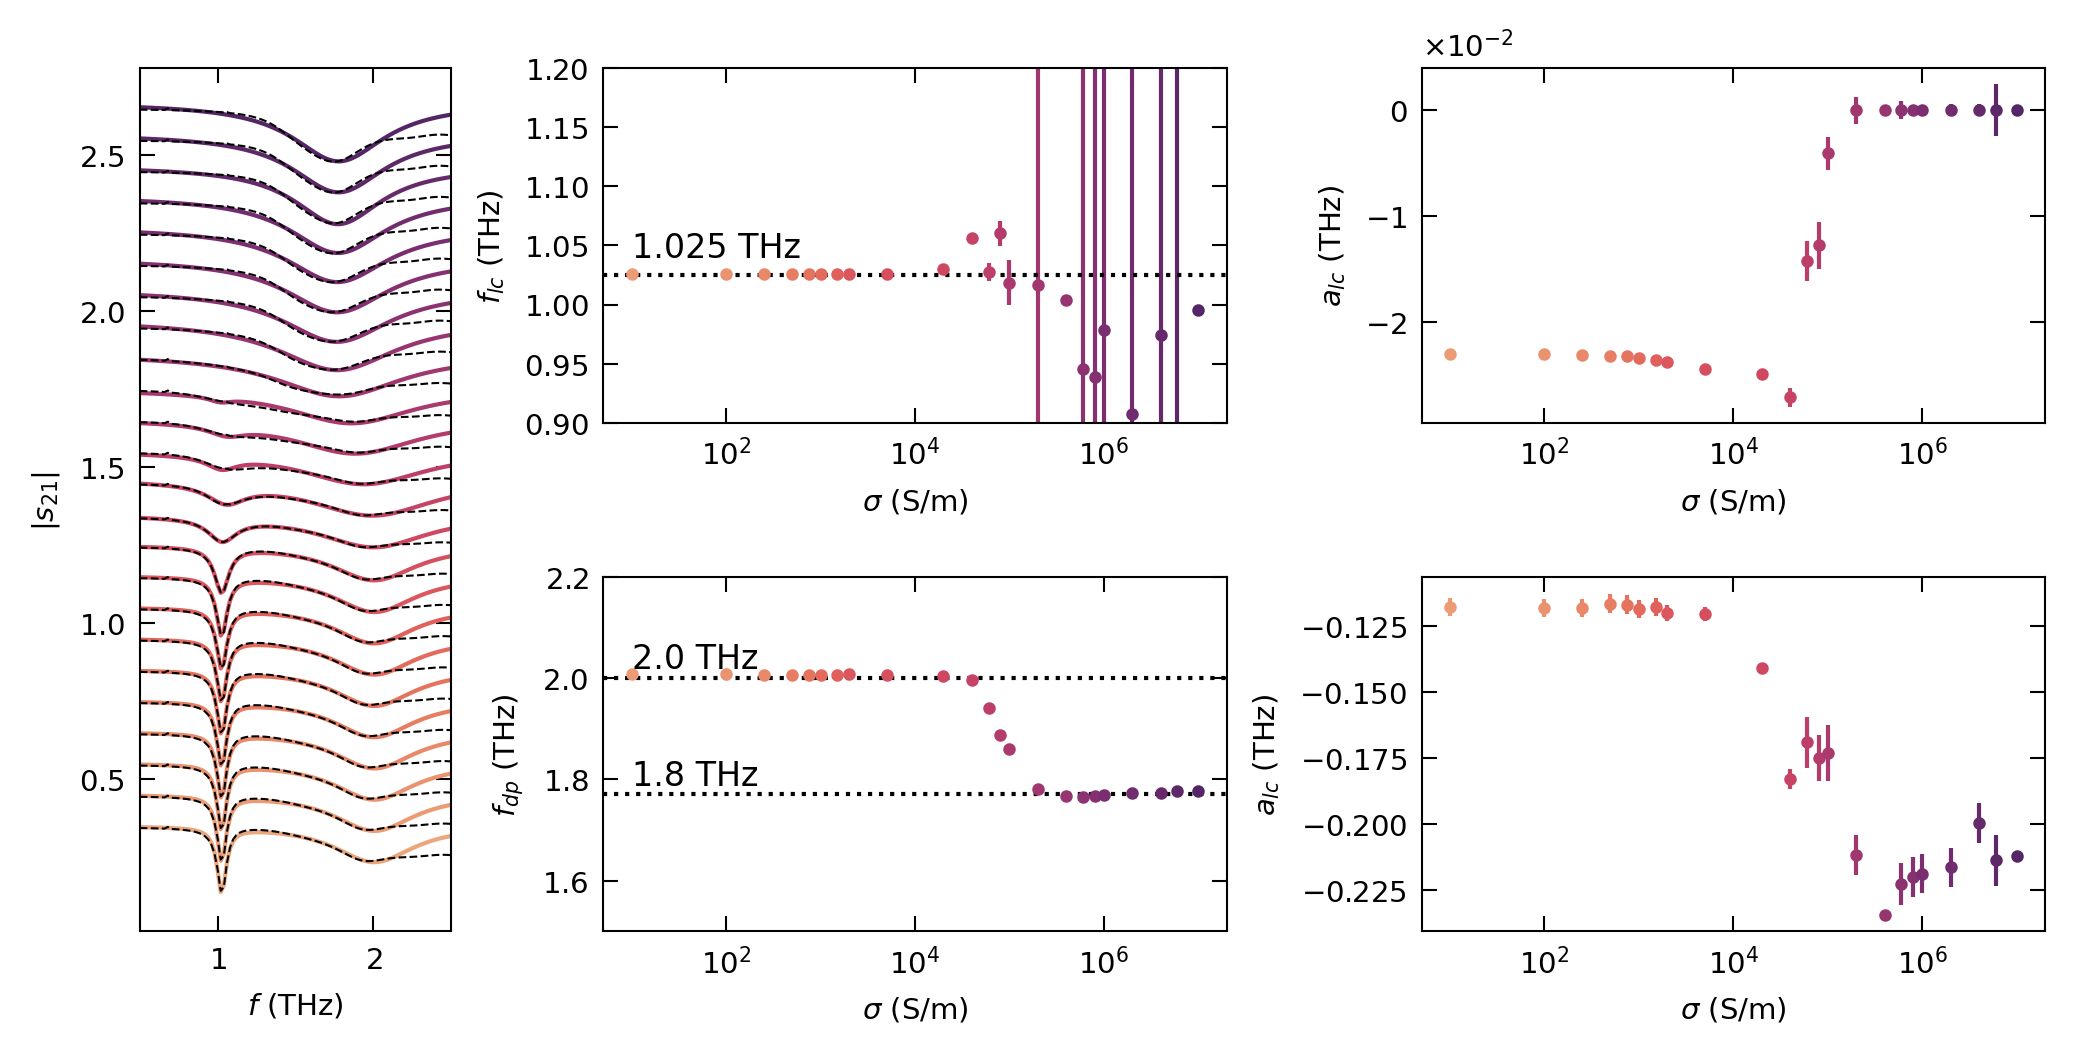

In [4]:
s21 = smatrix_data.filter(pl.col("param") == "s21.mag")

model = (
    lm.models.LorentzianModel(prefix="lc_")
    + lm.models.LorentzianModel(prefix="dp_")
    + lm.models.ConstantModel()
)

params = model.make_params()
params["c"].set(value=0.35, vary=True)

params["lc_amplitude"].set(value=-0.5, max=0, vary=True)
params["lc_center"].set(value=1.0, min=0.8, max=1.2, vary=True)
params["lc_sigma"].set(value=0.1, min=1e-2, max=2, vary=True)

params["dp_amplitude"].set(value=-0.2, max=0, vary=True)
params["dp_center"].set(value=2, min=1.5, max=2.5, vary=True)
params["dp_sigma"].set(value=0.1, min=1e-1, max=0.5, vary=True)

fig: plt.Figure = plt.figure(figsize=(6.8, 3.4), layout="constrained")
ax = fig.subplot_mosaic(
    [["specs", "lc_center", "lc_amplitude"], ["specs", "dp_center", "dp_amplitude"]],
    gridspec_kw={"width_ratios": [1, 2, 2]},
)

colors = sns.color_palette("flare", n_colors=len(s21["cond"].unique()))
for i, (cond, data) in enumerate(s21.groupby("cond", maintain_order=True)):
    weights = (data["freq"] < 2.2).cast(pl.Float64)
    res = model.fit(
        data["value"].to_numpy(),
        x=data["freq"].to_numpy(),
        weights=weights.to_numpy(),
        params=params,
    )

    ax["specs"].plot(data["freq"], i / 10 + res.best_fit, c=colors[i])
    ax["specs"].plot(data["freq"], i / 10 + data["value"], c="k", ls="--", lw=0.5)

    param_names = ("lc_center", "lc_amplitude", "dp_center", "dp_amplitude")
    for param in param_names:
        ax[param].errorbar(
            cond,
            res.params[param].value,
            yerr=res.params[param].stderr,
            marker="o",
            markersize=2,
            color=colors[i],
        )
        ax[param].set(
            xticks=[10**i for i in range(1, 8, 2)],
            xlabel=r"$\sigma$ (S/m)",
            xscale="log",
        )

ax["specs"].set(xlabel=r"$f$ (THz)", ylabel=r"$|s_{21}|$", xlim=(0.5, 2.5))
ax["lc_center"].set(
    ylabel=r"$f_{lc}$ (THz)",
    ylim=(0.9, 1.2),
)
ax["dp_center"].set(
    ylabel=r"$f_{dp}$ (THz)",
    ylim=(1.5, 2.2),
)
ax["lc_amplitude"].set(ylabel=r"$a_{lc}$ (THz)")
ax["dp_amplitude"].set(ylabel=r"$a_{lc}$ (THz)")

ax["lc_center"].axhline(1.025, c="k", ls=":")
ax["lc_center"].annotate("1.025 THz", xy=(1e1, 1.04), fontsize=8)
ax["dp_center"].axhline(2.00, c="k", ls=":")
ax["dp_center"].annotate("2.0 THz", xy=(1e1, 2.02), fontsize=8)
ax["dp_center"].axhline(1.77, c="k", ls=":")
ax["dp_center"].annotate("1.8 THz", xy=(1e1, 1.789), fontsize=8)

plt.show()

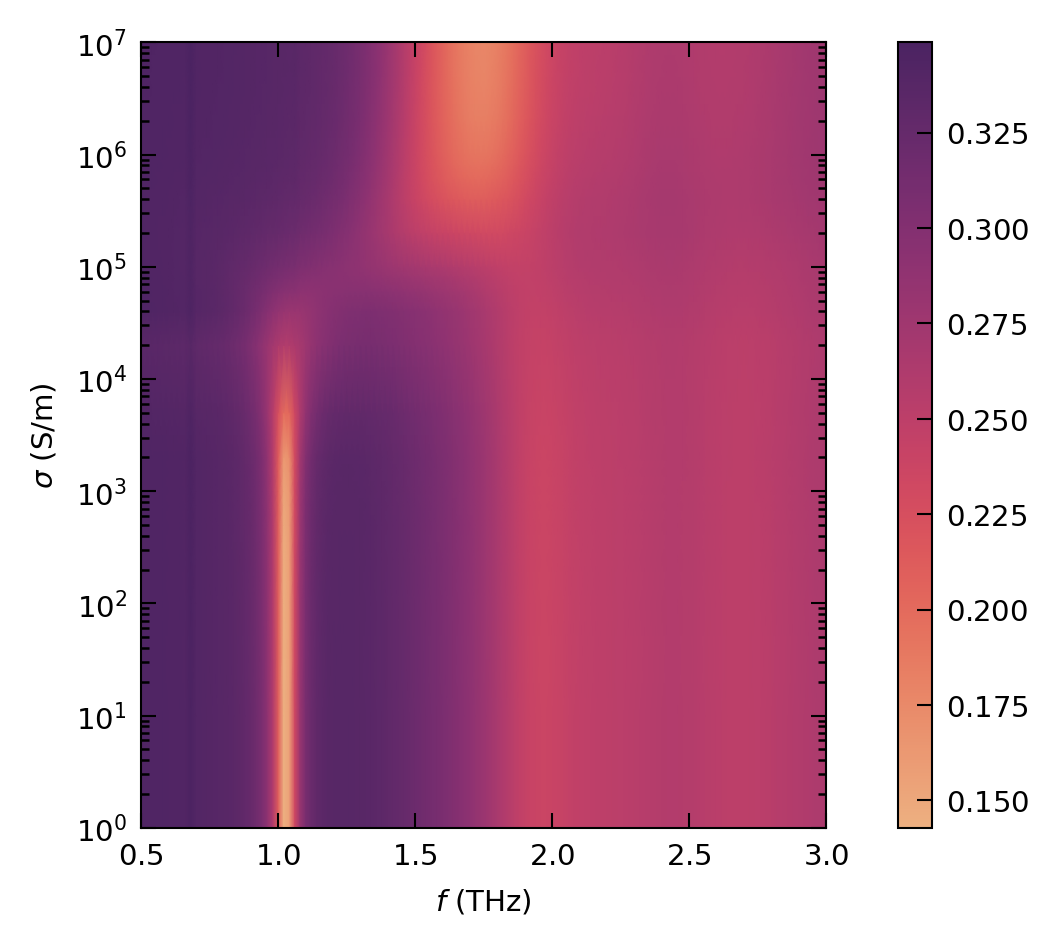

In [13]:
fig, ax = utils.plotting.plot_heatmap(
    smatrix_data.filter(pl.col("param") == "s21.mag").select("freq", "cond", "value")
)

ax["value"].set(
    yscale="log", ylim=(1, 1e7), xlabel=r"$f$ (THz)", ylabel=r"$\sigma$ (S/m)"
)
ax["colorbar"].set(label=r"$|s_{21}|$")

fig.savefig("figures/conductivity/s21map.pdf", bbox_inches="tight")
plt.show()

### Field profile

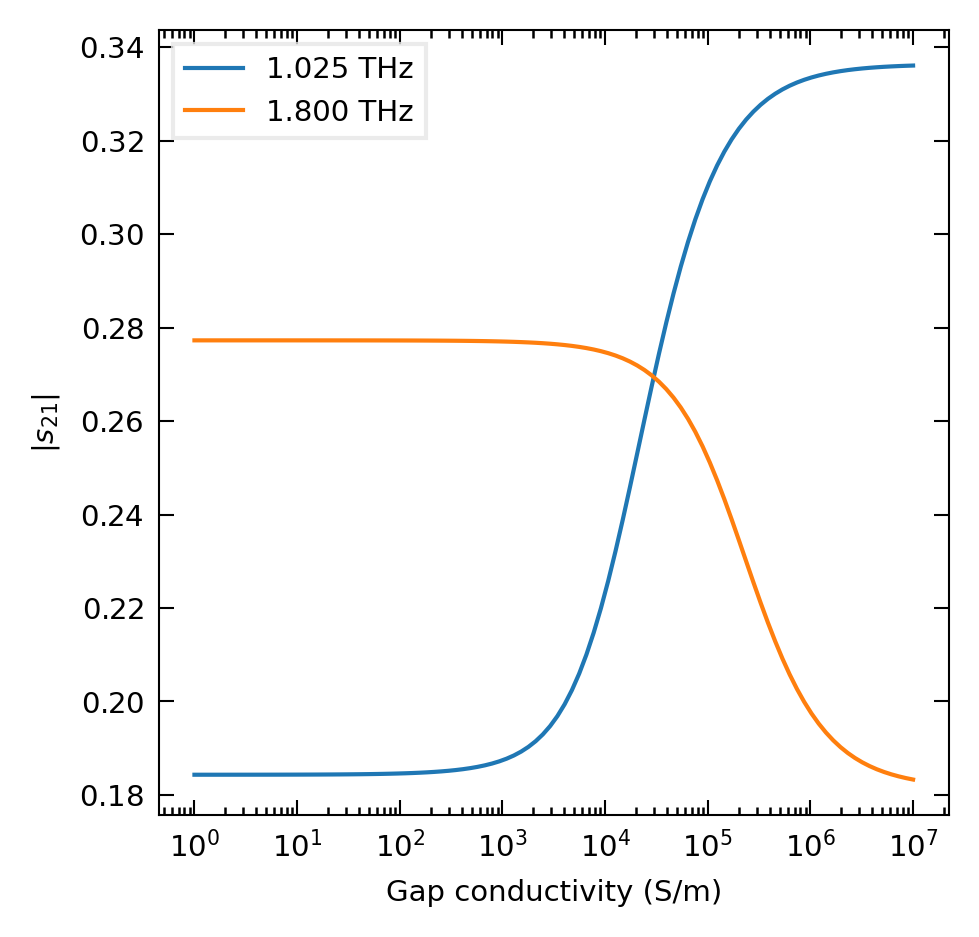

In [6]:
data = (
    pl.read_csv("data/21.06.23/smatrix_data.csv", comment_char="%")
    .with_columns(variable=pl.col("variable").str.strip(" (1)"))
    .pivot(
        values=["value"],
        index=["freq", "cond"],
        columns="variable",
        aggregate_function="first",
    )
)

fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))
for i, freq in enumerate((1.025, 1.800)):
    data_singlefreq = data.filter(pl.col("freq") == freq)
    cond = data_singlefreq["cond"]
    s21 = (data_singlefreq["s21.real"] ** 2 + data_singlefreq["s21.imag"] ** 2).sqrt()

    ax.plot(cond, s21, label=f"{freq:.3f} THz")
ax.set(xscale="log", ylabel=r"$|s_{21}|$", xlabel="Gap conductivity (S/m)")
ax.legend()
plt.show()

In [42]:
# - Import data
df = pl.scan_csv("data/21.06.23/surface_data.csv", comment_char="%")
filter_Ey = (pl.col("variable") == "Ey.real (V/m)") | (
    pl.col("variable") == "Ey.imag (V/m)"
)
data = (
    df.filter(filter_Ey)
    .collect()
    .pivot(
        values=["value"],
        index=["x", "y", "freq", "cond"],
        columns="variable",
        aggregate_function="first",
    )
)

frequencies = data["freq"].unique()
conductivities = data["cond"].unique()

data = data.with_columns(
    pl.Expr.sqrt(pl.col("Ey.real (V/m)") ** 2 + pl.col("Ey.imag (V/m)") ** 2).alias(
        "Ey.mag (V/m)"
    ),
).sort("x", "y")

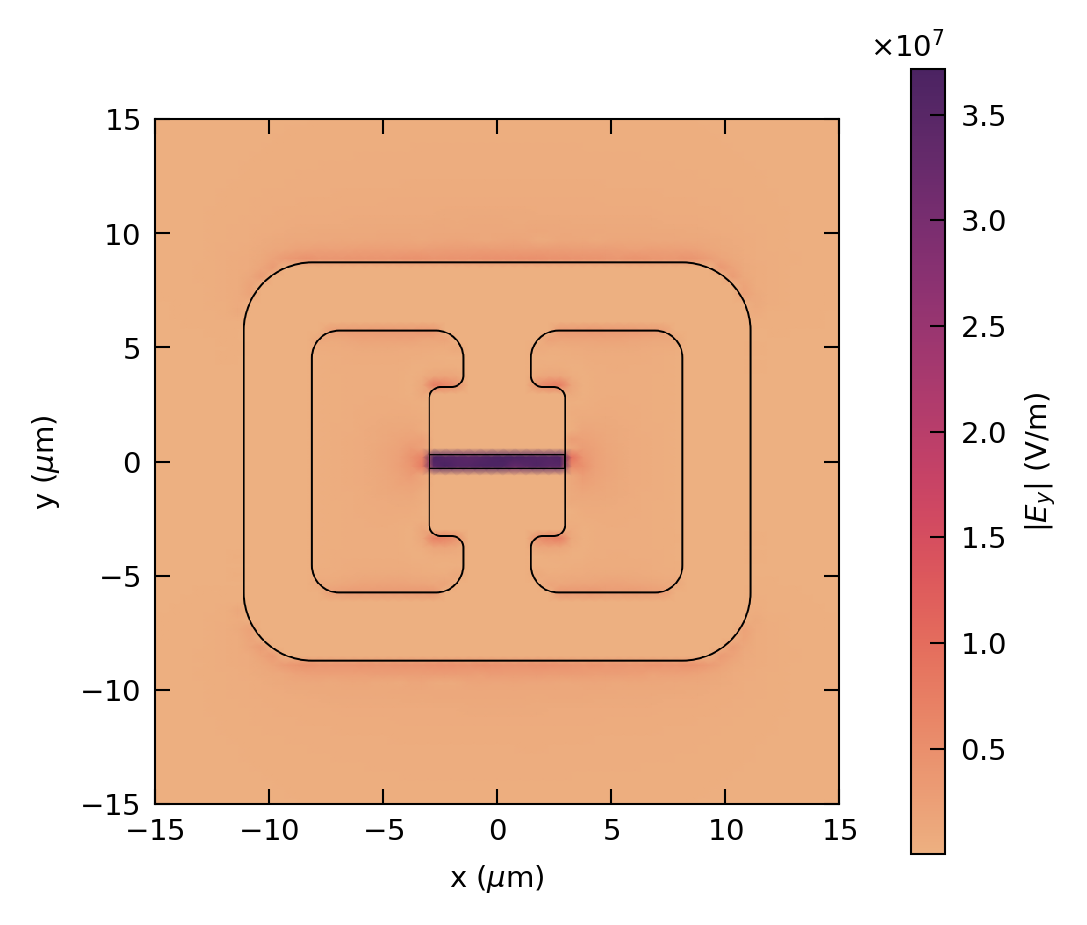

In [46]:
fig, ax = utils.plotting.plot_heatmap(
    data.filter(
        (pl.col("freq") == 1.025) & (pl.col("cond") == pl.col("cond").min())
    ).select("x", "y", "Ey.mag (V/m)"),
)
ax["value"].set_aspect("equal")
ax["value"].set(
    xlim=(-15, 15), ylim=(-15, 15), xlabel=r"x ($\mu$m)", ylabel=r"y ($\mu$m)"
)

utils.plotting.plot_dxf(
    "cad/F21059.dxf",
    extent=(data["x"].min(), data["x"].max(), data["y"].min(), data["y"].max()),
    ax=ax["value"],
)
ax["colorbar"].set(ylabel=r"$|E_y|$ (V/m)")

plt.show()

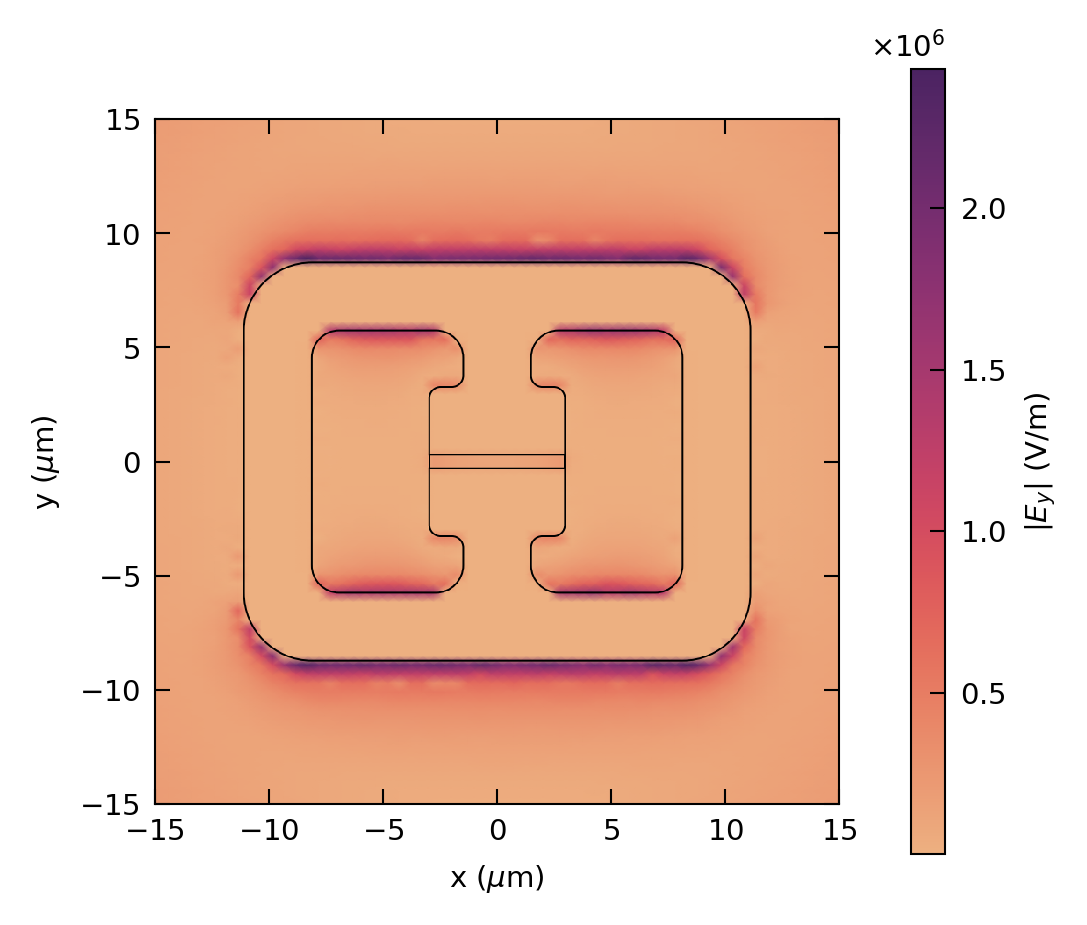

In [48]:
fig, ax = utils.plotting.plot_heatmap(
    data.filter(
        (pl.col("freq") == 1.8) & (pl.col("cond") == pl.col("cond").max())
    ).select("x", "y", "Ey.mag (V/m)"),
)
ax["value"].set_aspect("equal")
ax["value"].set(
    xlim=(-15, 15), ylim=(-15, 15), xlabel=r"x ($\mu$m)", ylabel=r"y ($\mu$m)"
)

utils.plotting.plot_dxf(
    "cad/F21059.dxf",
    extent=(data["x"].min(), data["x"].max(), data["y"].min(), data["y"].max()),
    ax=ax["value"],
)
ax["colorbar"].set(ylabel=r"$|E_y|$ (V/m)")

plt.show()

## Drude model

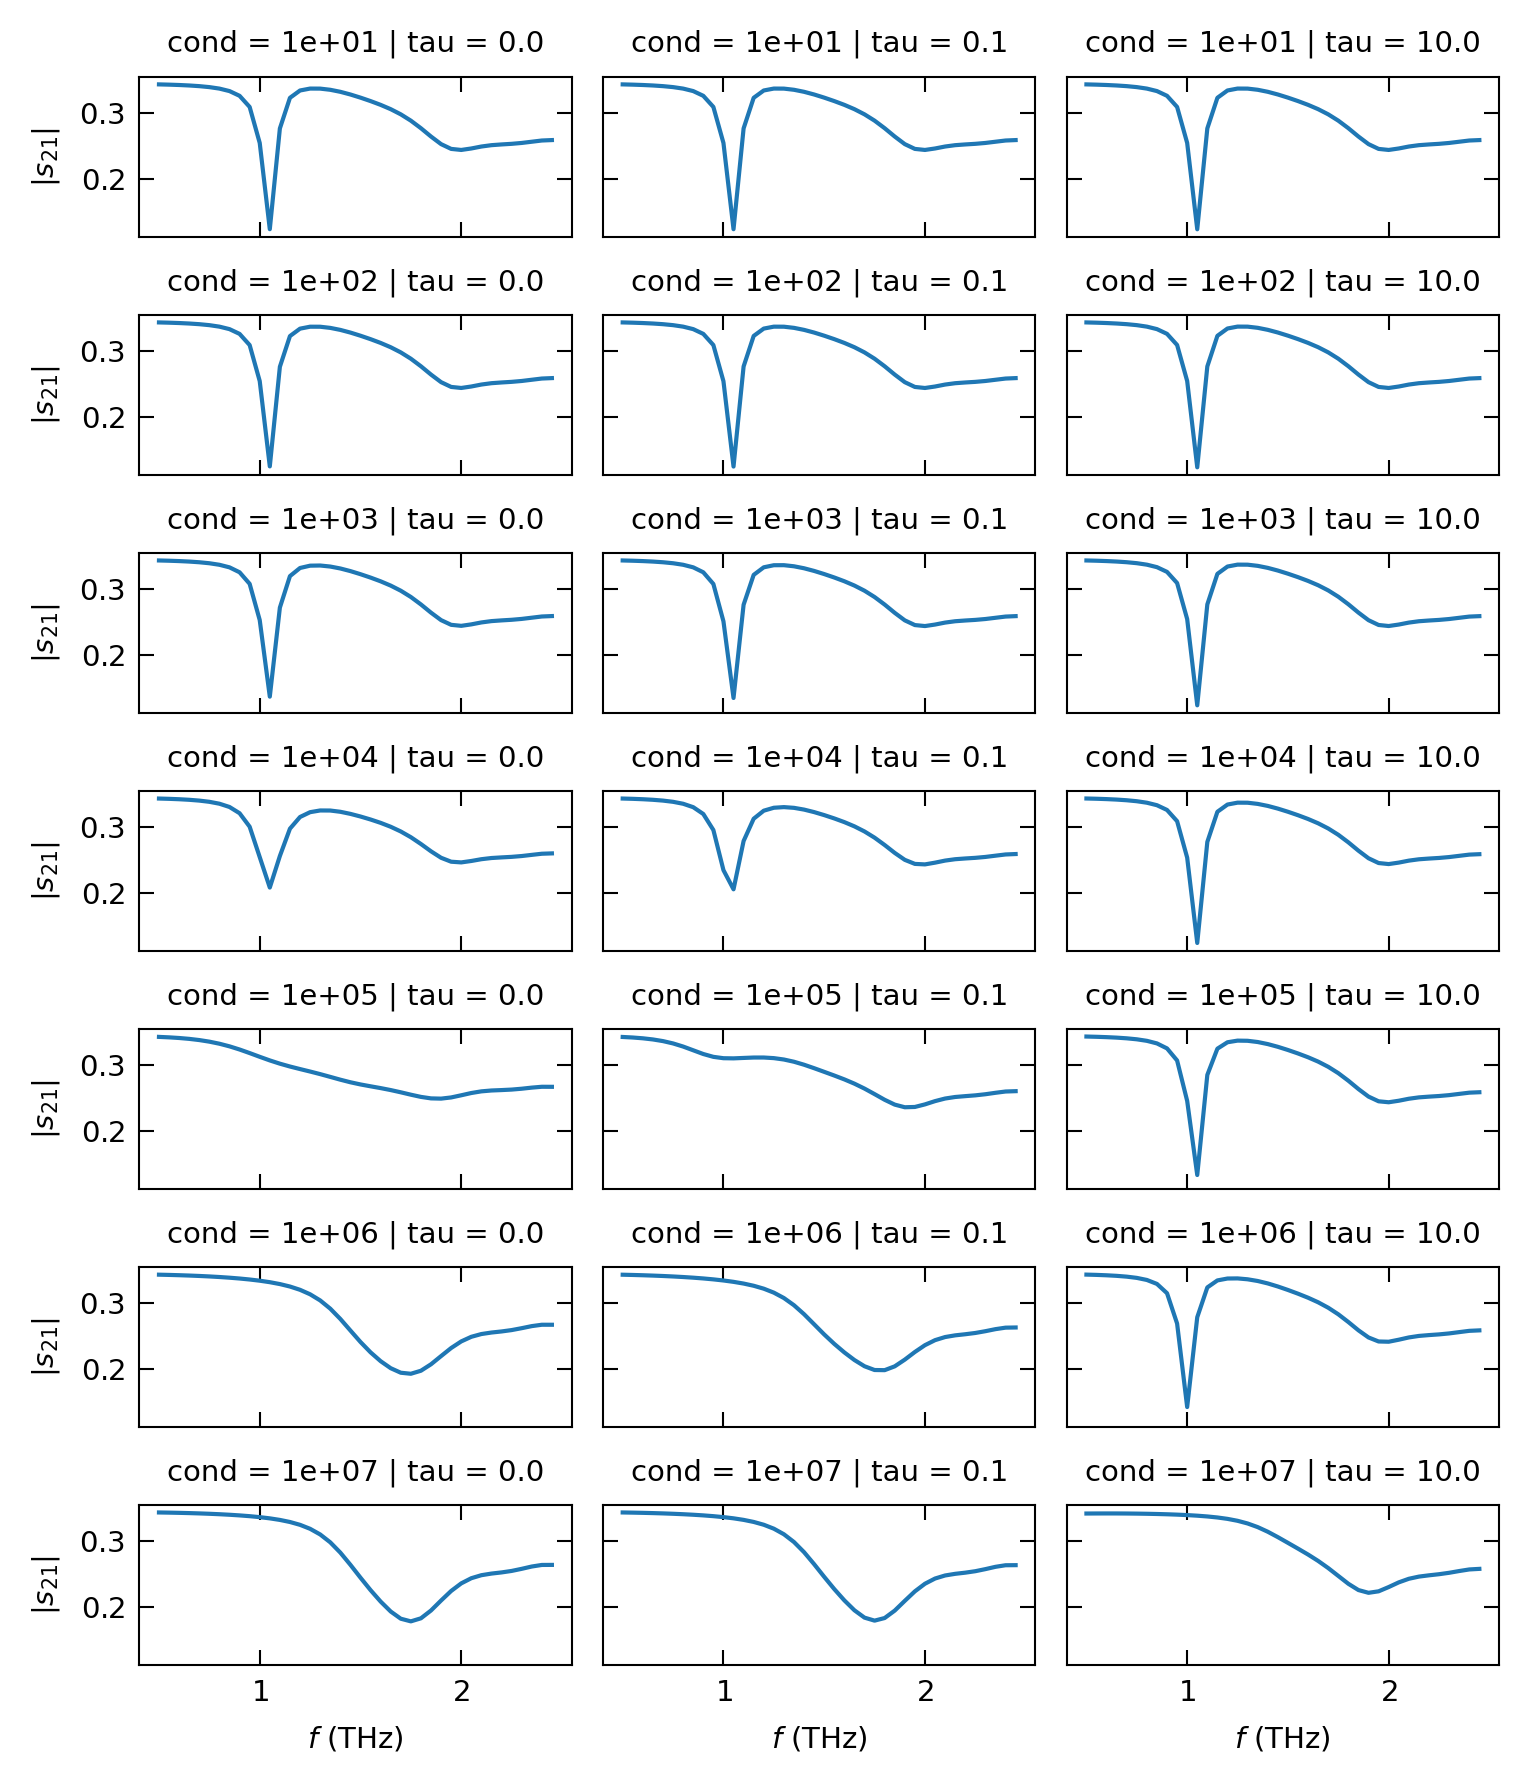

In [103]:
df = (
    pl.scan_csv("data/28.06.23/smatrix_data.csv", comment_char="%")
    .filter(pl.col("variable").is_in(["s21.real", "s21.imag"]))
    .collect()
    .pivot(
        values="value",
        index=["freq", "cond", "tau"],
        columns="variable",
        aggregate_function=None,
    )
    .with_columns(
        pl.col("cond").apply(lambda x: f"{x:.0e}"),
        pl.Expr.sqrt(pl.col("s21.real").pow(2) + pl.col("s21.imag").pow(2)).alias(
            "s21.mag"
        ),
    )
    .to_pandas()
)
g = sns.FacetGrid(
    df,
    col="tau",
    row="cond",
    sharex=True,
    sharey=True,
    height=0.85,
    aspect=2,
    despine=False,
)
g.map_dataframe(sns.lineplot, x="freq", y="s21.mag")

for ax in g.axes.flat:
    ax.set(ylabel=r"$|s_{21}|$", xlabel=r"$f$ (THz)")

fig.savefig("figures/conductivity/cond_tau_table.pdf", bbox_inches="tight")
plt.show()

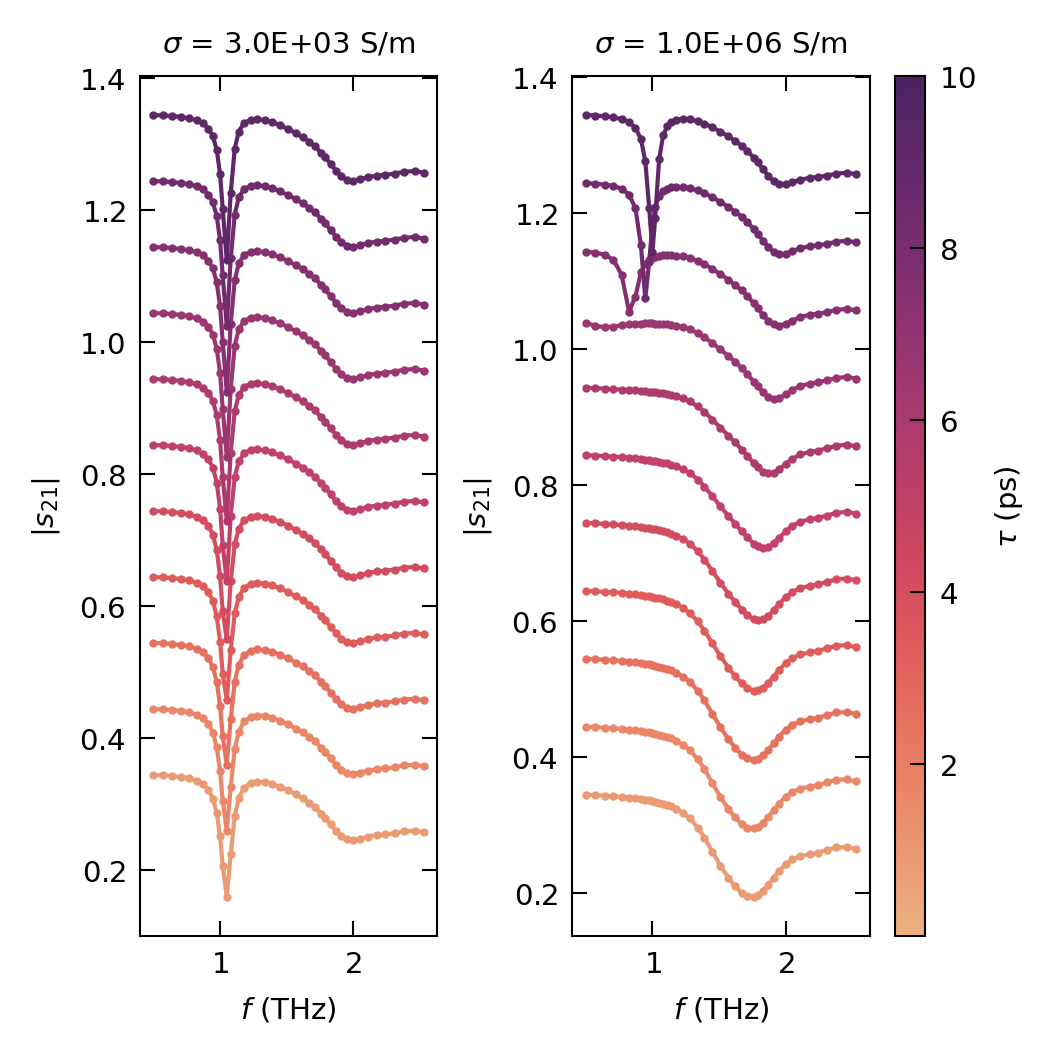

In [109]:
df = pl.scan_csv("data/29.06.23/smatrix_data.csv", comment_char="%")

cond = df.select(pl.col("cond")).unique().sort("cond").collect().to_numpy()[:, 0]
tau = df.select(pl.col("tau")).unique().sort("tau").collect().to_numpy()[:, 0]

fig = plt.figure(layout="constrained")
gs = fig.add_gridspec(1, len(cond) + 1, width_ratios=(1, 1, 0.1))
ax = [fig.add_subplot(gs[0, i]) for i in range(len(cond))]
cax = fig.add_subplot(gs[0, -1])

cmap_name = "flare"
cmap = sns.color_palette(cmap_name, len(tau))
for i in range(len(cond)):
    df_real = df.filter((pl.col("cond") == cond[i])).filter(
        pl.col("variable") == "s21.real (1)"
    )
    df_imag = df.filter((pl.col("cond") == cond[i])).filter(
        pl.col("variable") == "s21.imag (1)"
    )
    for j in range(len(tau)):
        real = df_real.filter(pl.col("tau") == tau[j]).collect()
        imag = df_imag.filter(pl.col("tau") == tau[j]).collect()
        mag = np.sqrt((real["value"] ** 2 + imag["value"] ** 2))
        f = real["freq"]
        ax[i].plot(f, mag + 1e-1 * j, label=f"{tau[j]}", c=cmap[j], marker="o", ms=1)

    ax[i].set(
        xlabel=r"$f$ (THz)",
        ylabel=r"$|s_{21}|$",
        title=f"$\sigma$ = {cond[i]:.1E} S/m",
    )

norm = Normalize(vmin=tau[0], vmax=tau[-1])
sm = plt.cm.ScalarMappable(cmap=sns.color_palette(cmap_name, as_cmap=True), norm=norm)
fig.colorbar(sm, cax=cax, label=r"$\tau$ (ps)")

fig.savefig("figures/conductivity/cond_tau.pdf", bbox_inches="tight")
plt.show()

In [117]:
files = list(
    filter(lambda x: x.endswith(".csv"), os.listdir("data/26.05.23/film_conductivity"))
)
files

['smatrix_2.00E+03.csv',
 'smatrix_2.00E+05.csv',
 'smatrix_2.00E+04.csv',
 'smatrix_2.00E+06.csv',
 'smatrix_8.00E+04.csv',
 'smatrix_8.00E+05.csv',
 'smatrix_8.00E+06.csv',
 'smatrix_0.00E+00.csv',
 'smatrix_5.00E+03.csv',
 'smatrix_6.00E+06.csv',
 'smatrix_6.00E+05.csv',
 'smatrix_6.00E+04.csv',
 'smatrix_1.00E+05.csv',
 'smatrix_1.00E+06.csv',
 'smatrix_1.00E+02.csv',
 'smatrix_4.00E+06.csv',
 'smatrix_1.00E+03.csv',
 'smatrix_1.00E+01.csv',
 'smatrix_4.00E+04.csv',
 'smatrix_4.00E+05.csv']

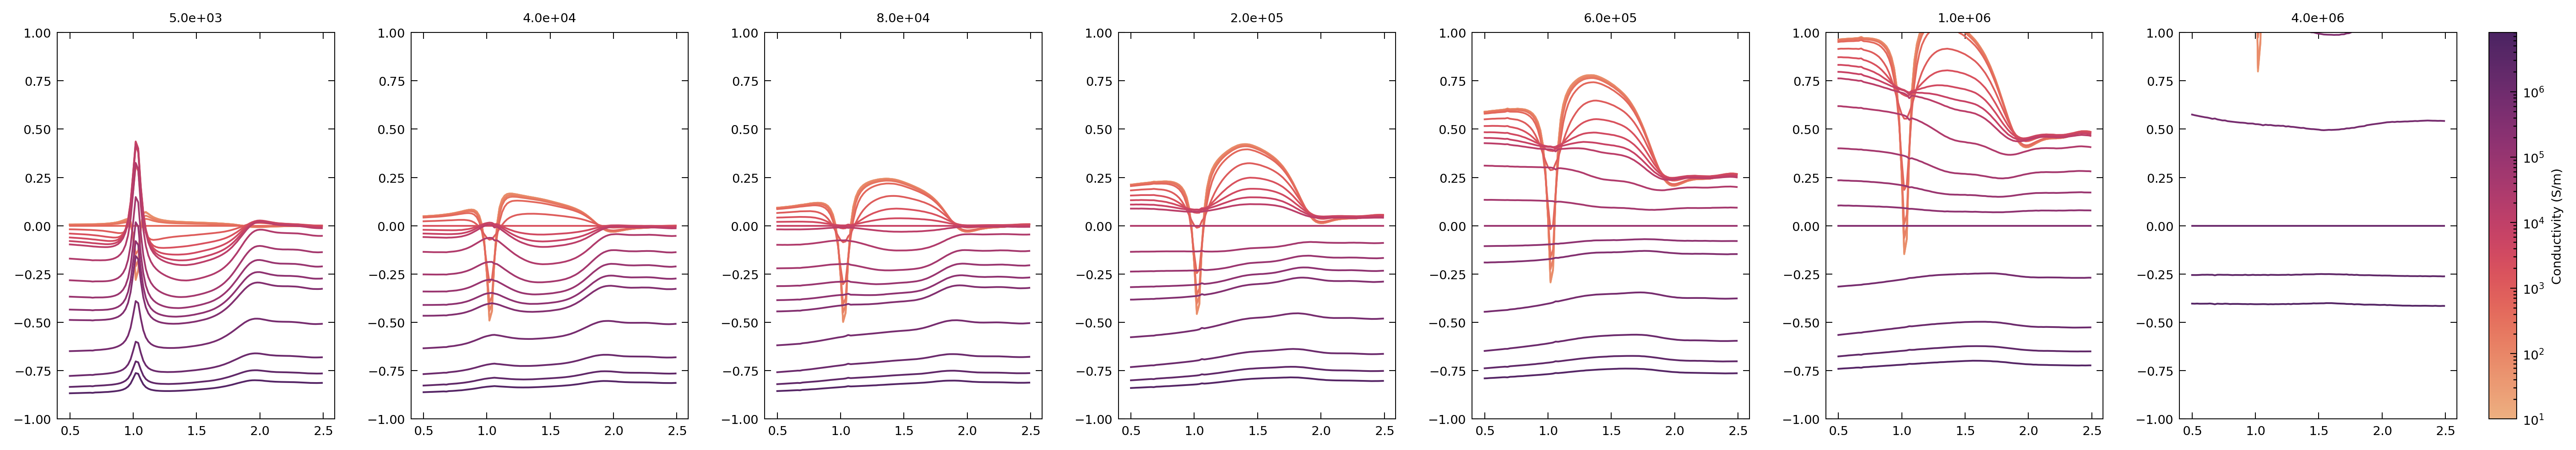

In [ ]:
files = list(
    filter(lambda x: x.endswith(".csv"), os.listdir("data/26.05.23/film_conductivity"))
)
files = sorted(files, key=get_num_from_filename)
cond = list(map(get_num_from_filename, files))


def struct_norm(x):
    return pl.Expr.sqrt(x.struct[0].pow(2) + x.struct[1].pow(2))


data = pl.concat(
    pl.read_csv("data/26.05.23/film_conductivity/" + file, comment_char="%")
    .rename({"freq (THz)": "freq"})
    .with_columns(
        pl.lit(get_num_from_filename(file)).alias("cond"),
        pl.struct("s21.real", "s21.imag").map(struct_norm).alias("s21.mag"),
        pl.struct("s11.real", "s11.imag").map(struct_norm).alias("s11.mag"),
    )
    for file in files
)
data = data.unpivot(index=("cond", "freq"))


cond_hitemp = cond[5:-2:2]
fig = plt.figure(figsize=(20, 3.4), layout="constrained")
gs = fig.add_gridspec(
    1,
    len(cond_hitemp) + 1,
    width_ratios=[*[1 for _ in range(len(cond_hitemp))], 0.1],
    wspace=0.1,
)

ax, cax = (
    [None for _ in range(len(cond_hitemp))],
    [None for _ in range(len(cond_hitemp))],
)
for i in range(len(cond_hitemp)):
    ax[i] = fig.add_subplot(gs[0, i])

    data_s21 = (
        data.filter(pl.col("variable") == "s21.mag")
        .drop("variable")
        .sort(["cond", "freq"])
    )
    s21_hitemp = data_s21.filter(pl.col("cond") == cond_hitemp[i])["value"]
    if len(s21_hitemp) == 126:
        data_s21 = (
            data_s21.pivot(
                index="freq", columns="cond", values="value", aggregate_function=None
            )
            .with_columns((pl.col("*").exclude("freq") - s21_hitemp) / s21_hitemp)
            .unpivot(index="freq", variable_name="cond")
            .with_columns(pl.col("cond").cast(float))
        )

    f_c = np.arange(0.5, 2.5, 1e-2)
    cmap = sns.color_palette("flare", len(cond))
    for j in range(len(cond)):
        s21 = np.interp(
            f_c,
            data_s21.filter(pl.col("cond") == cond[j])["freq"],
            data_s21.filter(pl.col("cond") == cond[j])["value"],
        )
        ax[i].plot(f_c, s21, c=cmap[j])
    ax[i].set(ylim=(-1, 1), title=f"{cond_hitemp[i]:.1e}")

# Colorbar
cax = fig.add_subplot(gs[0, -1])
norm = LogNorm(vmin=cond[1], vmax=cond[-1])
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
fig.colorbar(sm, cax=cax, label="Conductivity (S/m)")

plt.show()

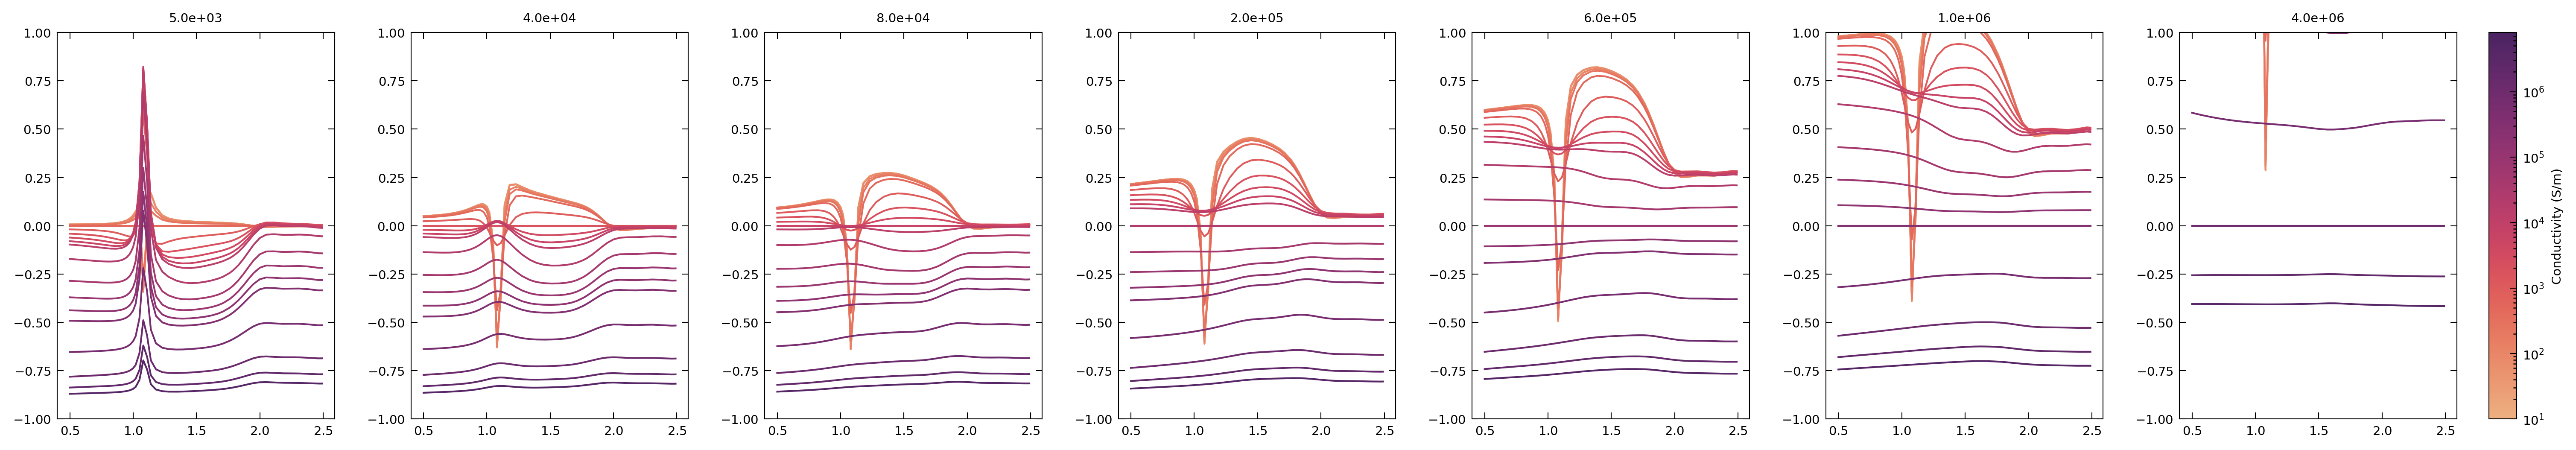

In [ ]:
data = (
    pl.scan_csv("data/24.07.23/smatrix_literature_lsat.csv", comment_char="#")
    .with_columns(variable=pl.col("variable").str.strip(" (1)"))
    .collect()
    .pivot(
        values=["value"],
        index=["freq", "cond"],
        columns="variable",
        aggregate_function="first",
    )
    .with_columns(
        [
            pl.Expr.sqrt(pl.col("s21.real") ** 2 + pl.col("s21.imag") ** 2).alias(
                "s21.mag"
            ),
            pl.Expr.sqrt(pl.col("s11.real") ** 2 + pl.col("s11.imag") ** 2).alias(
                "s11.mag"
            ),
        ]
    )
    .unpivot(index=["freq", "cond"])
)
cond = data.select(pl.col("cond")).unique().sort("cond").to_numpy()[:, 0]

cond_hitemp = cond[5:-2:2]
fig = plt.figure(figsize=(20, 3.4), layout="constrained")
gs = fig.add_gridspec(
    1,
    len(cond_hitemp) + 1,
    width_ratios=[*[1 for _ in range(len(cond_hitemp))], 0.1],
    wspace=0.1,
)

ax, cax = (
    [None for _ in range(len(cond_hitemp))],
    [None for _ in range(len(cond_hitemp))],
)
for i in range(len(cond_hitemp)):
    ax[i] = fig.add_subplot(gs[0, i])

    data_s21 = (
        data.filter(pl.col("variable") == "s21.mag")
        .drop("variable")
        .sort(["cond", "freq"])
    )
    s21_hitemp = data_s21.filter(pl.col("cond") == cond_hitemp[i])["value"]

    data_s21 = (
        data_s21.pivot(
            index="freq", columns="cond", values="value", aggregate_function=None
        )
        .with_columns((pl.col("*").exclude("freq") - s21_hitemp) / s21_hitemp)
        .unpivot(index="freq", variable_name="cond")
        .with_columns(pl.col("cond").cast(float))
    )

    f_c = np.arange(0.5, 2.5, 1e-2)
    cmap = sns.color_palette("flare", len(cond))
    for j in range(len(cond)):
        s21 = np.interp(
            f_c,
            data_s21.filter(pl.col("cond") == cond[j])["freq"],
            data_s21.filter(pl.col("cond") == cond[j])["value"],
        )
        ax[i].plot(f_c, s21, c=cmap[j])
    ax[i].set(ylim=(-1, 1), title=f"{cond_hitemp[i]:.1e}")

# Colorbar
cax = fig.add_subplot(gs[0, -1])
norm = LogNorm(vmin=cond[1], vmax=cond[-1])
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
fig.colorbar(sm, cax=cax, label="Conductivity (S/m)")

plt.show()